##3.2 线性回归的从零开始实现
&emsp;&emsp;在了解线性回归的背景知识后，现在我们来动手实现它。尽管强大的深度学习框架可以减少大量重复性工作，但过于依赖它提供的便利性，会导致我们很难深入理解深度学习是如何工作的。因此，本节介绍如何利用GradientTape() API来实现一个线性回归的训练。\
&emsp;&emsp;首先，导入本节实验中所需的包或模块，其中的matplotlib包可用于作图，且设置成嵌入显示。


In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as pyplot
import tensorflow as tf
import random
import numpy as np

tf.enable_eager_execution() #启用动态图计算

### 3.2.1 生成数据集
&emsp;&emsp;我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学习到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2.给定随机生成的批量样本特征$X \in R^{1000 \times2}$,我们使用线性回归模型的真实权重$w=[2,-3,4]^T$和偏差b=4.2，以及一个随机噪声$\epsilon$来生成标签
$$y=Xw+b+\epsilon ,$$
&emsp;&emsp;其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [0]:
num_inputs=2
num_examples=1000
true_w=[2,-3.4]
true_b=4.2
features=tf.random.normal(shape=(num_examples,num_inputs),stddev=1)
labels=true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b
labels+=tf.random.normal(shape=(tf.shape(labels)),stddev=0.01)

&emsp;&emsp;注意，features的每一行是一个长度为2的向量，而labels的每一行是一个长度为1的向量(标量)。

In [3]:
features.shape,labels.shape

(TensorShape([Dimension(1000), Dimension(2)]), TensorShape([Dimension(1000)]))

In [4]:
features[0].numpy(),labels[0].numpy()

(array([1.2928032 , 0.15362471], dtype=float32), 6.266954)

&emsp;&emsp;通过生成第二个特征features[:,1]和标签labels的散点图，可以更加直观地观察两者间的线性关系。

In [0]:
def use_svg_display():
  #用矢量图显示
  display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
  use_svg_display()
  #设置图的尺寸
  pyplot.rcParams['figure.figsize']=figsize

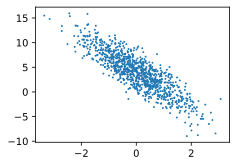

In [6]:
set_figsize()
pyplot.scatter(features[:,1].numpy(),labels.numpy(),1)

###3.2.2. 读取数据
&emsp;&emsp;在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签。

In [0]:
def data_iter(batch_size,features,labels):
  num_examples=len(features)
  indices=list(range(num_examples))
  random.shuffle(indices)
  for i in range(0,num_examples,batch_size):
    j=np.array(indices[i:min(i+batch_size,num_examples)])
    yield tf.gather(features,j),tf.gather(labels,j)

&emsp;&emsp;读取第一个小批量数据样本并打印。每个批量的特征形状为(10,2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [8]:
batch_size=10
for X,y in data_iter(batch_size,features,labels):
  print(X,y)
  break

tf.Tensor(
[[-0.21719383 -1.0593973 ]
 [-0.3221357  -0.3451354 ]
 [-2.080672    0.2445377 ]
 [-0.06064635  0.77870834]
 [-0.7390014  -0.74971086]
 [ 0.37659824  0.05508694]
 [ 0.07542281  1.5092013 ]
 [-1.0215837  -0.44589254]
 [-1.1662717   0.08145095]
 [ 1.7653456  -0.19372146]], shape=(10, 2), dtype=float32) tf.Tensor(
[ 7.375232    4.724717   -0.78952575  1.4377736   5.2782164   4.756109
 -0.77351546  3.6853657   1.5922009   8.390103  ], shape=(10,), dtype=float32)


###3.2.3. 初始化模型参数
&emsp;&emsp;将权重初始化成均值为0、标准差为0.01的正太随机数，偏差则初始化成0.

In [0]:
w=tf.Variable(tf.random.normal(shape=(num_inputs,1),mean=0,stddev=0.01))
b=tf.Variable(tf.zeros(shape=(1,)))

In [10]:
w.shape,b.shape

(TensorShape([Dimension(2), Dimension(1)]), TensorShape([Dimension(1)]))

### 3.2.4. 定义模型
&emsp;&emsp;下面是线性回归的矢量计算表达式的实现。使用tf.matmul()做矩阵乘法。

In [0]:
def linreg(X,w,b):
  return tf.matmul(X,w)+b

### 3.2.5. 定义损失函数
&emsp;&emsp;我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值y变形成预测值y_hat的形状。以下函数返回的结果也将和y_hat的形状相同。

In [0]:
def squared_loss(y_hat,y):
  return (y_hat-tf.reshape(y,shape=y_hat.shape))**2/2

### 3.2.6. 定义优化算法
&emsp;&emsp;以下的sgd函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [0]:
def sgd(params,loss,t,lr,batch_size):
  for param in params:
    dl_dp=t.gradient(l,param) #求梯度
    param.assign_sub(lr*dl_dp/batch_size) #更新梯度

### 3.2.7.训练模型
&emsp;&emsp;在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取到的小批量数据样本(特征X和y)，通过反向传播计算小批量随机梯度，然后调用优化算法sgd迭代模型参数。由于我们之前设批量大小batch_size为10，每个小批量的损失l的形状为(10, 1)。回忆一下“自动求梯度”一节。由于变量l并不是一个标量，运行t.gradient(l,param)将对l中元素求和得到新的变量，再求该变量有关模型参数的梯度。
&emsp;&emsp;在一个迭代周期（epoch）中，我们将完整遍历一遍data_iter函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [14]:
lr=0.03
num_epochs=3
net=linreg
loss=squared_loss

for epoch in range(num_epochs):
  for X,y in data_iter(batch_size,features,labels):
    with tf.GradientTape(persistent=True) as t:
      t.watch([w,b])
      l=loss(net(X,w,b),y)
    sgd([w,b],l,t,lr,batch_size)
  train_l=loss(net(features,w,b),labels)
  print('epoch %d,loss %f'%(epoch+1,tf.reduce_mean(train_l).numpy()))


epoch 1,loss 0.045622
epoch 2,loss 0.000181
epoch 3,loss 0.000047


&emsp;&emsp;比较学习到的参数和真实参数，应该很接近

In [15]:
true_w,w

([2, -3.4], <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
 array([[ 1.999975 ],
        [-3.3994184]], dtype=float32)>)

In [16]:
true_b,b

(4.2,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.1995173], dtype=float32)>)

### 3.2.8小结
* 可以看出，仅使用Tensor和GradientTape() API就可以很容易地实现一个模型。接下来会在此基础上描述更多深度学习模型，并介绍怎样使用更简洁地代码(见下一节)来实现它们。
  